In [2]:
############################################## Importing Libraries ##############################################

In [194]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report , recall_score ,  precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier


In [195]:
############################################## Data Loading Starts Here #############################################

In [196]:
#Lets prepare our data for modeling
flight_details = pd.read_csv('Flights_Jan_2019_ontime.csv')
flight_details.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
0,1,2,9E,20363,9E,N8688C,3280,11953,1195302,GNV,...,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,NaN
1,1,2,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,...,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,NaN
2,1,2,9E,20363,9E,N8896A,3282,11433,1143302,DTW,...,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,NaN
3,1,2,9E,20363,9E,N8886A,3283,15249,1524906,TLH,...,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,NaN
4,1,2,9E,20363,9E,N8974C,3284,10397,1039707,ATL,...,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,NaN


In [197]:
############################################## Data Preparation Starts Here #############################################

In [198]:
# check the columns
flight_details.columns

Index(['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER',
       'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN',
       'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST', 'DEP_TIME',
       'DEP_DEL15', 'DEP_TIME_BLK', 'ARR_TIME', 'ARR_DEL15', 'CANCELLED',
       'DIVERTED', 'DISTANCE', 'Unnamed: 21'],
      dtype='object')

In [199]:
# check type of columns:
flight_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583985 entries, 0 to 583984
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   DAY_OF_MONTH           583985 non-null  int64  
 1   DAY_OF_WEEK            583985 non-null  int64  
 2   OP_UNIQUE_CARRIER      583985 non-null  object 
 3   OP_CARRIER_AIRLINE_ID  583985 non-null  int64  
 4   OP_CARRIER             583985 non-null  object 
 5   TAIL_NUM               581442 non-null  object 
 6   OP_CARRIER_FL_NUM      583985 non-null  int64  
 7   ORIGIN_AIRPORT_ID      583985 non-null  int64  
 8   ORIGIN_AIRPORT_SEQ_ID  583985 non-null  int64  
 9   ORIGIN                 583985 non-null  object 
 10  DEST_AIRPORT_ID        583985 non-null  int64  
 11  DEST_AIRPORT_SEQ_ID    583985 non-null  int64  
 12  DEST                   583985 non-null  object 
 13  DEP_TIME               567633 non-null  float64
 14  DEP_DEL15              567630 non-nu

In [200]:
#We want to predict if someflight will delayed in any time - arrival or departure. So lets create new classifier, named under "delayed" with 2 result
#Delayed - 1 the flight will delay
#Delayed - 0 the flight will not delay
flight_details['DELAYED'] = (flight_details['ARR_DEL15'].astype(bool) | 
                                         flight_details['DEP_DEL15'].astype(bool)).astype(int)

In [201]:
print("The number of rows before deleted 'Cancelled' column and `DIVERTED` is " + str(flight_details.shape[0]) )

flight_details.drop(flight_details[flight_details.CANCELLED == 1].index, inplace=True)

flight_details.drop(flight_details[flight_details.DIVERTED == 1].index, inplace=True)

print("The number of rows after deleted 'Cancelled' column and `DIVERTED` is " + str(flight_details.shape[0]) )

The number of rows before deleted 'Cancelled' column and `DIVERTED` is 583985
The number of rows after deleted 'Cancelled' column and `DIVERTED` is 565963


In [202]:
#Lets get rid of unuseful columns, that not impact on our results
flight_details.drop(['OP_CARRIER_AIRLINE_ID','TAIL_NUM','OP_CARRIER_FL_NUM',
                                 'ORIGIN_AIRPORT_ID','ORIGIN_AIRPORT_SEQ_ID','DEST_AIRPORT_ID','DEST_AIRPORT_SEQ_ID',
                                 'Unnamed: 21','OP_CARRIER','ARR_DEL15','DEP_DEL15','CANCELLED', 'DIVERTED'], axis='columns',
                                inplace=True)

In [203]:
#Lets check distribution of our target variable
flight_details['DELAYED'].value_counts()

0    440724
1    125239
Name: DELAYED, dtype: int64

In [204]:
#We can see that there is very high difference between the rows with value 1 and 0 , so we should decrease our rows with value 0.
# Split the data into positive and negative
pos = flight_details.loc[flight_details.DELAYED == 1]
neg = flight_details.loc[flight_details.DELAYED == 0]

# Merge the balanced data
data = pd.concat([pos, neg.sample(n = len(pos))], axis = 0)

# Shuffle the order of data
flight_details = data.sample(n = len(data)).reset_index(drop = True)

In [205]:
#Lets rename names if needed for more readble
flight_details = flight_details.rename(columns={"OP_UNIQUE_CARRIER": "AIRLINE_CODE"})

In [206]:
#Check for some Null/Na values
flight_details.isna().sum()

DAY_OF_MONTH    0
DAY_OF_WEEK     0
AIRLINE_CODE    0
ORIGIN          0
DEST            0
DEP_TIME        0
DEP_TIME_BLK    0
ARR_TIME        0
DISTANCE        0
DELAYED         0
dtype: int64

In [207]:
#now we dont have any null values

In [208]:
print("Our final data include: " + str(flight_details.shape[0]) + " Rows and " + str(flight_details.shape[1]) + " Columns" )

Our final data include: 250478 Rows and 10 Columns


In [209]:
 flight_details.head()

,DAY_OF_MONTH,DAY_OF_WEEK,AIRLINE_CODE,ORIGIN,DEST,DEP_TIME,DEP_TIME_BLK,ARR_TIME,DISTANCE,DELAYED
0,12,6,AS,SJC,JFK,726.0,0700-0759,1713.0,2569.0,1
1,22,2,AA,ORD,DFW,1908.0,1800-1859,2152.0,801.0,1
2,20,7,MQ,CMH,LGA,830.0,0600-0659,1056.0,479.0,1
3,2,3,9E,DTW,DAY,1205.0,1200-1259,1309.0,166.0,0
4,10,4,F9,DEN,MCO,1247.0,1200-1259,1745.0,1546.0,1


In [210]:
############################################## Data Preparation Ends Here #############################################

array([[<AxesSubplot:title={'center':'DAY_OF_MONTH'}>,
        <AxesSubplot:title={'center':'DAY_OF_WEEK'}>],
       [<AxesSubplot:title={'center':'DEP_TIME'}>,
        <AxesSubplot:title={'center':'ARR_TIME'}>],
       [<AxesSubplot:title={'center':'DISTANCE'}>,
        <AxesSubplot:title={'center':'DELAYED'}>]], dtype=object)

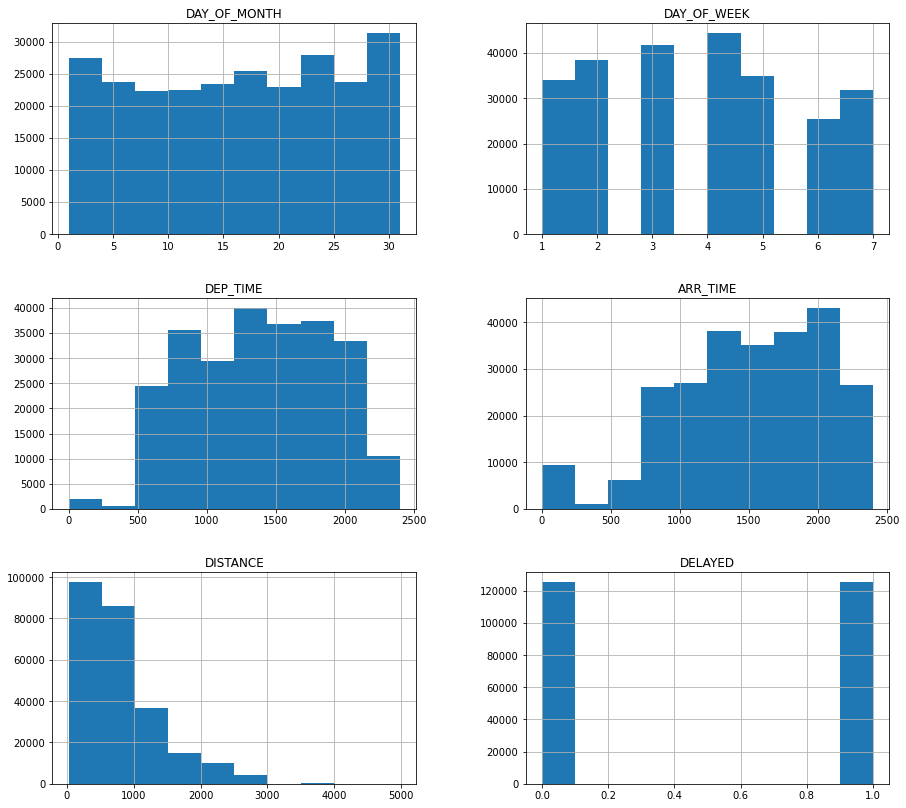

In [211]:
#Exploratory Data Analysis
flight_details.hist(figsize= (15, 14))

In [212]:
 flight_details.describe()

,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,ARR_TIME,DISTANCE,DELAYED
count,250478.000000,250478.000000,250478.000000,250478.000000,250478.000000,250478.000000
mean,15.984805,3.843296,1384.875965,1511.666701,811.544531,0.500000
std,9.027344,1.912996,497.642486,549.426882,594.967009,0.500001
min,1.000000,1.000000,1.000000,1.000000,31.000000,0.000000
25%,8.000000,2.000000,959.000000,1129.000000,370.000000,0.000000
50%,16.000000,4.000000,1414.000000,1552.000000,651.000000,0.500000
75%,24.000000,5.000000,1808.000000,1947.000000,1050.000000,1.000000
max,31.000000,7.000000,2400.000000,2400.000000,4983.000000,1.000000


In [213]:
#First Lets see if there some dfference between airline companies delay, due to result we can understand if there problem with spesific company

<AxesSubplot:xlabel='AIRLINE_CODE'>

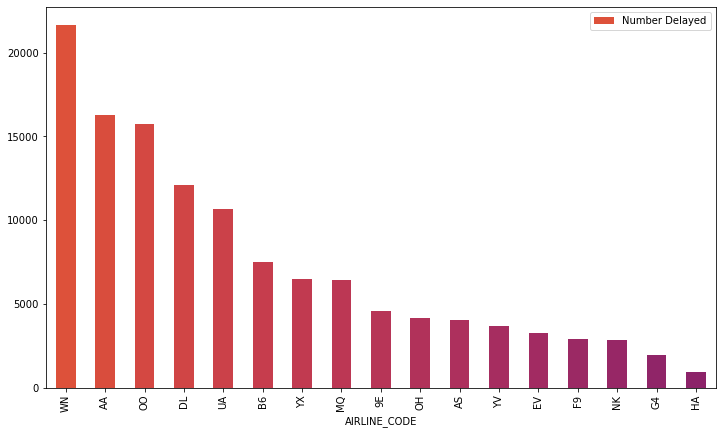

In [214]:
# Count delayed by company
count_delayed=flight_details.groupby('AIRLINE_CODE')['DELAYED'].apply(lambda x: (x==1).sum()).reset_index(name='Number Delayed')

color = cm.inferno_r(np.linspace(.4, .8, 30))
count_delayed= count_delayed.sort_values("Number Delayed" , ascending=[False])
count_delayed.plot.bar(x='AIRLINE_CODE', y='Number Delayed', color=color , figsize=(12,7))

In [215]:
#Correlation between the day of the month to number of delays

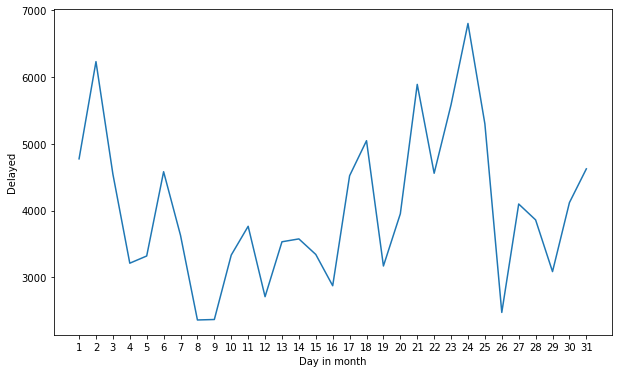

In [216]:
monthly_days_delayed=flight_details.groupby('DAY_OF_MONTH')['DELAYED'].apply(lambda x: (x==1).sum()).reset_index(name='Number Delayed')
plt.figure(figsize=(10, 6))
plt.xticks(monthly_days_delayed['DAY_OF_MONTH'])
plt.plot(monthly_days_delayed['DAY_OF_MONTH'],monthly_days_delayed['Number Delayed'])
plt.ylabel('Delayed')
plt.xlabel('Day in month')
plt.show()

In [217]:
#Now lets see if there any corellation between the distance and delays

Avergae Distance with delay: 828.707846597306 mile
Avergae Distance without delay: 794.3812151166969 mile


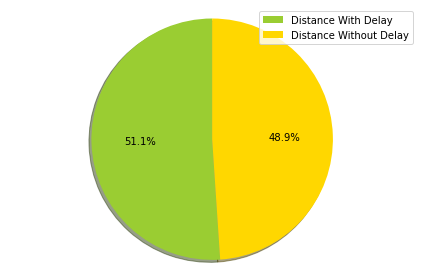

In [218]:
#Calculate the percent of delays with average distance:
avg_distance_delay = flight_details[flight_details['DELAYED'] == 1]['DISTANCE'].values.mean()
#Calculate the precent of delays without average distance:
avg_distance_without_delay = flight_details[flight_details['DELAYED'] == 0]['DISTANCE'].values.mean()

print("Avergae Distance with delay: " + str(avg_distance_delay) + " mile")
print("Avergae Distance without delay: "+ str(avg_distance_without_delay) +" mile")

labels = ['Distance With Delay', 'Distance Without Delay']
sizes = [avg_distance_delay,avg_distance_without_delay]
colors = ['yellowgreen', 'gold']
texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, autopct='%1.1f%%')
plt.legend(labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [219]:
#Let's see in which day are the higher number of delays:=

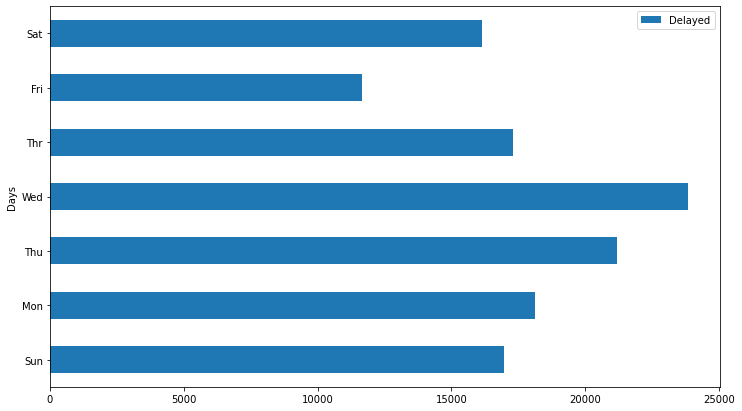

In [220]:
# Create the data for the days adays_values
days_values = flight_details.groupby('DAY_OF_WEEK')['DELAYED'].apply(lambda x: (x==1).sum()).reset_index(name='Number Delayed')
days_values.sort_values("DAY_OF_WEEK" )

days_values['DAY_OF_WEEK'] = days_values['DAY_OF_WEEK'].map({1: 'Sun', 2: 'Mon', 3:'Thu',4:'Wed',5:'Thr',6:'Fri',7:'Sat'})

df = pd.DataFrame({'Days':days_values['DAY_OF_WEEK'],'Delayed':days_values['Number Delayed']})
ax = df.plot.barh(x='Days',y='Delayed',figsize=(12,7))

In [221]:
#We have to encode our categorial Variabels before we move to modeling:

# OP_UNIQUE_CARRIER
# ORIGIN
# DEST
# DEST_TIME_BLK

In [222]:
def encode_categories(features):
    lb_make = LabelEncoder()
    for i in range(len(features)):
        flight_details[features[i]] = lb_make.fit_transform(flight_details[features[i]])

In [223]:
encode_categories(['AIRLINE_CODE','ORIGIN','DEST','DEP_TIME_BLK',])
flight_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250478 entries, 0 to 250477
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   DAY_OF_MONTH  250478 non-null  int64  
 1   DAY_OF_WEEK   250478 non-null  int64  
 2   AIRLINE_CODE  250478 non-null  int32  
 3   ORIGIN        250478 non-null  int32  
 4   DEST          250478 non-null  int32  
 5   DEP_TIME      250478 non-null  float64
 6   DEP_TIME_BLK  250478 non-null  int32  
 7   ARR_TIME      250478 non-null  float64
 8   DISTANCE      250478 non-null  float64
 9   DELAYED       250478 non-null  int32  
dtypes: float64(3), int32(5), int64(2)
memory usage: 14.3 MB


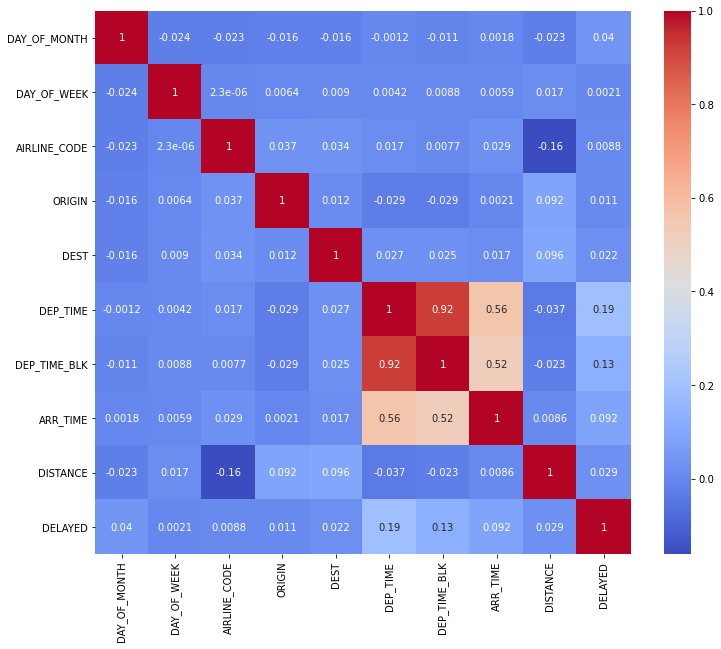

In [224]:
#Collerations between our features
plt.figure(figsize = (12, 10))
sns.heatmap(flight_details.corr(), annot = True, cmap = 'coolwarm')
plt.show()

In [225]:
########################################### MODELING ###########################################

In [226]:
# Create test and train:
feature_names = ['DAY_OF_MONTH','DAY_OF_WEEK','AIRLINE_CODE','ORIGIN','DEST','DEP_TIME','DEP_TIME_BLK','ARR_TIME','DISTANCE']
X =  flight_details[feature_names].values
y =  flight_details['DELAYED'].values

In [227]:
# SPLIT THE DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [228]:
### DECISION TREE Modeling

In [229]:
dt = DecisionTreeClassifier(max_depth=15)
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=15)

In [230]:
### ADA BOOST CLASSIFIER

In [231]:
ab = AdaBoostClassifier()
ab.fit(X_train, y_train)

AdaBoostClassifier()

In [232]:
###  RandomForestClassifier

In [233]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 350,max_depth=14,min_samples_leaf=15,min_samples_split=5, n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=14, min_samples_leaf=15, min_samples_split=5,
                       n_estimators=350, n_jobs=-1)

In [236]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

In [237]:
###  GradientBoosting

In [238]:
gb = GradientBoostingClassifier()
gb.fit(X_train,y_train)

GradientBoostingClassifier()

In [239]:
########################################### EVALUATION ###########################################

In [240]:
#Evaluating of accuarcy of our models

In [241]:
# Acurracy of each model
def get_accuracy(model):
        pred = model[0].predict(X_test)
        check_overfitting(model)
        return accuracy_score(y_test, pred)

In [242]:
def check_overfitting(model):
        pred = model[0].predict(X_test)
        over_fit_check_pred = model[0].predict(X_train)
        print('Checking '+ model[1] + ' Overffiting:')
        print('Train Accuracy ' + str(accuracy_score(y_train, over_fit_check_pred)))
        print('Test Accuracy ' + str(accuracy_score(y_test, pred)))
        print('--------------------------')

In [243]:
# Plot the confusion matrix for each model:
def get_confusion_matrix(model):
    from sklearn.metrics import plot_confusion_matrix
    class_names=['Delay-False','Delay-true']
    disp = plot_confusion_matrix(model[0], X_test, y_test,
                                     display_labels=class_names, values_format='d',
                                     cmap=model[2])
    precision = precision_score(y_test, model[0].predict(X_test), average='binary')
    recall = recall_score(y_test, model[0].predict(X_test), average='binary')
    
    print("Model : {}".format(model[0]))
    print('Avg Precision:' +  str(precision))
    print('Avg Recall:' + str(recall))
    
    disp.ax_.set_title(model[1])
    plt.show()

In [244]:
### Save the accuracy
models = [[rf,'Random Forest',plt.cm.Blues],[gb,'Gradient Boosting',plt.cm.Greens],[dt,'Decision Tree',plt.cm.Reds],[ab,'AdaBoost',plt.cm.Oranges]]
#models = [[dt,'Decision Tree',plt.cm.Reds],[ab,'AdaBoost',plt.cm.Oranges]]
accuracy = []
for model in models:
    accuracy.append(get_accuracy(model))

Checking Random Forest Overffiting:
Train Accuracy 0.8260919160003194
Test Accuracy 0.7993186415415735
--------------------------
Checking Gradient Boosting Overffiting:
Train Accuracy 0.7747727194953631
Test Accuracy 0.7725699989353774
--------------------------
Checking Decision Tree Overffiting:
Train Accuracy 0.8321375203896563
Test Accuracy 0.786835941658682
--------------------------
Checking AdaBoost Overffiting:
Train Accuracy 0.6644290325892297
Test Accuracy 0.6645241137016927
--------------------------


Model : RandomForestClassifier(max_depth=14, min_samples_leaf=15, min_samples_split=5,
                       n_estimators=350, n_jobs=-1)
Avg Precision:0.8353271083798216
Avg Recall:0.7454806847528022


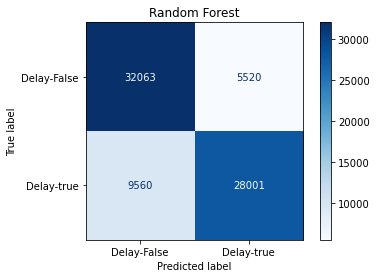

Model : GradientBoostingClassifier()
Avg Precision:0.8599359988747055
Avg Recall:0.6510476291898512


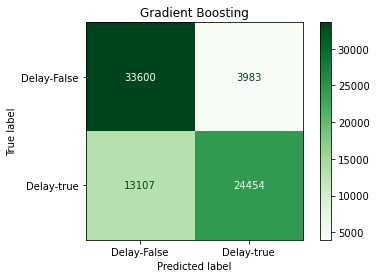

Model : DecisionTreeClassifier(max_depth=15)
Avg Precision:0.8419198171602704
Avg Recall:0.7061313596549612


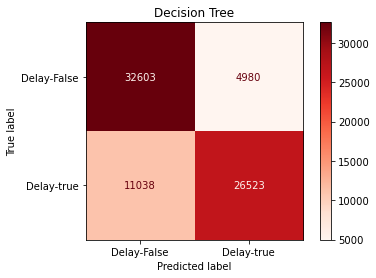

Model : AdaBoostClassifier()
Avg Precision:0.6624664597253643
Avg Recall:0.6704560581454168


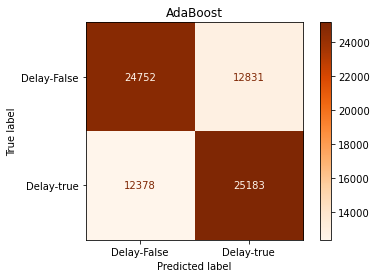

In [245]:
#Show the confusion matrix for each model with Recall and Precision
for model in models:
    get_confusion_matrix(model)

In [246]:
#Plot accurcay of each model

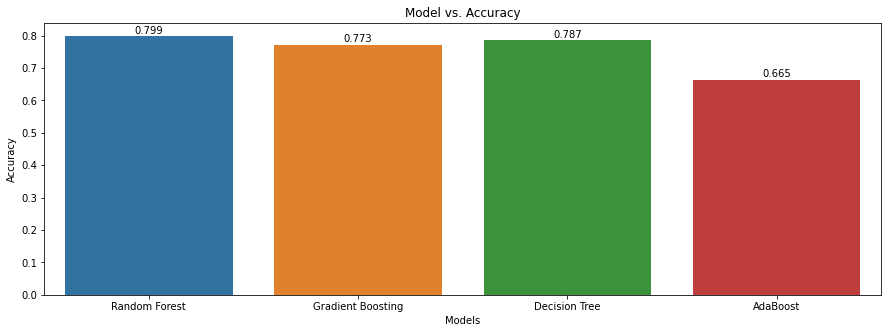

<Figure size 432x288 with 0 Axes>

In [247]:
plt.figure(figsize=(15,5))
#model_names = ['Decision Tree','AdaBoost']
model_names = ['Random Forest','Gradient Boosting','Decision Tree','AdaBoost']
ax = sns.barplot(x = model_names, y =accuracy)

accuracy_dic = dict(zip(model_names, accuracy))

for p, value in zip(ax.patches, list(accuracy_dic.values())):
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 0.008
    ax.text(_x, _y, round(value, 3), ha="center") 

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model vs. Accuracy")
plt.figure(figsize=(6,4))
plt.show()

In [248]:
print(classification_report(y_test, dt.predict(X_test), target_names=['Delayed','Not Delayed']))

              precision    recall  f1-score   support

     Delayed       0.75      0.87      0.80     37583
 Not Delayed       0.84      0.71      0.77     37561

    accuracy                           0.79     75144
   macro avg       0.79      0.79      0.79     75144
weighted avg       0.79      0.79      0.79     75144



In [249]:
#Feature Importance

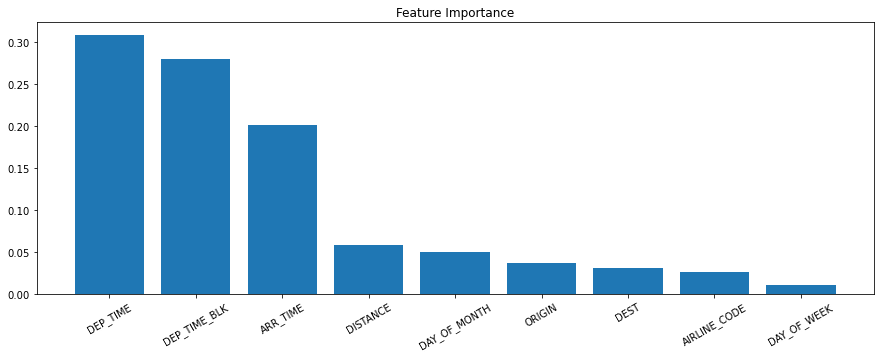

In [250]:
importances = rf.feature_importances_
features = list(flight_details.columns)
indices = np.argsort(importances)[::-1]

names = [features[i] for i in indices]

plt.figure(figsize=(15,5))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=30, fontsize = 10)
plt.title("Feature Importance")
plt.show()

In [251]:
#the optimization takes 20 minutes, for avoid long run time ,you can see the code and the result in report

In [254]:

rf_old_accur = accuracy[0]

rf = RandomForestClassifier(n_estimators=200, min_samples_split=5, max_features='sqrt', max_depth=45)
rf.fit(X_train,y_train)

pred = rf.predict(X_test)
rf_new_accur = accuracy_score(y_test, pred)

print("The Accuracy of RandomForest Model before tuning: " + str(rf_old_accur))
print("The Accuracy of RandomForest Model after tuning: " + str(rf_new_accur))

print("Increase of : " + str(100-((rf_old_accur * 100 ) / rf_new_accur ))+' %')

The Accuracy of RandomForest Model before tuning: 0.7993186415415735
The Accuracy of RandomForest Model after tuning: 0.8425955498775684
Increase of : 5.136142523216876 %


In [253]:
####################################################### END :) ##########################################################